<a href="https://colab.research.google.com/github/norifujimura/AlvaAR-ja/blob/main/pg_gan_256px.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ColabNotebooks/pg-gan

/content/drive/MyDrive/ColabNotebooks/pg-gan


In [6]:
import torch
torch.cuda.empty_cache()

In [7]:
!nvidia-smi

Sun Dec 14 21:32:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

 PGGAN （256px Progressive Growing）

ランタイムの初期化（推奨）

In [8]:
# ランタイム初期化（推奨）
import os, gc, torch
gc.collect()
torch.cuda.empty_cache()

依存ライブラリのインストール

In [9]:
!pip install opencv-python torch torchvision tqdm

動画から画像を抽出（256px 正方形）

In [11]:
import cv2
import os

# ---- 設定 ----
VIDEO_PATH = "stainedglass/stainedglass-720p.mp4"  # あなたの動画をここに置く
OUTPUT_DIR = "stainedglass/256x1200/frames"
TARGET_SIZE = 256
FPS_EXTRACT = 4   # ← ここを変更すれば枚数を増減可能

os.makedirs(OUTPUT_DIR, exist_ok=True)

cap = cv2.VideoCapture(VIDEO_PATH)
orig_fps = cap.get(cv2.CAP_PROP_FPS)

frame_interval = max(1, int(orig_fps / FPS_EXTRACT))

count = 0
saved = 0

print(f"Original FPS: {orig_fps}, extracting {FPS_EXTRACT} fps")

while True:
    ret = cap.grab()
    if not ret:
        break

    # 必要分だけフレーム抽出
    if count % frame_interval == 0:
        ret, frame = cap.retrieve()
        if not ret:
            break

        h, w, _ = frame.shape
        size = min(h, w)
        start_x = (w - size) // 2
        start_y = (h - size) // 2
        square = frame[start_y:start_y + size, start_x:start_x + size]

        resized = cv2.resize(square, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_AREA)

        out_path = f"{OUTPUT_DIR}/frame_{saved:05d}.png"
        cv2.imwrite(out_path, resized)
        saved += 1

    count += 1

cap.release()

print(f"抽出完了：{saved} 枚の画像を保存しました")

Original FPS: 25.326239745161043, extracting 4 fps
抽出完了：1278 枚の画像を保存しました


Dataset の準備（PGGAN用）

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob

DATA_DIR = "stainedglass/256x1200/frames"

transform = transforms.Compose([
    transforms.Resize((256,256)),     # ★ 必須 ★
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class ImageFolderDataset(Dataset):
    def __init__(self, folder):
        self.paths = sorted(glob.glob(folder + "/*.png"))
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img)

dataset = ImageFolderDataset(DATA_DIR)
print("画像数：", len(dataset))

画像数： 1278


DataLoader（安定設定）
PGGAN 初期フェーズは画像が小さいため
batch=32〜64 でも動きますが、
品質を優先して batch=32 を推奨。

In [13]:
loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

print("loader OK, total images:", len(dataset))

loader OK, total images: 1278


 ここまでが「データ準備フェーズ」

Generator & Discriminator
PGGAN のコアアイデア：   
	1.	4×4 から始める.  
	2.	各解像度で block を追加.  
	3.	既存ネットと新block の間を fade-in（α）で連結.  
	4.	toRGB / fromRGB を解像度ごとに用意.  
	5.	最終的に 256×256 に到達.  

Resolution
Channels.  
4×4
512.  
8×8
512.  
16×16
512.  
32×32
256.  
64×64
128.  
128×128
64.  
256×256
32.  


PixelNorm（G用）

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, eps=1e-8):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + eps)

Equalized Learning Rate 層（PGGAN特有）
この技術により、PGGAN の安定性が劇的に向上します。

In [4]:
import math

class EqualizedConv2d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, stride=1, padding=0):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_ch, in_ch, kernel, kernel))
        self.bias = nn.Parameter(torch.zeros(out_ch))
        self.scale = (2 / (in_ch * kernel * kernel)) ** 0.5
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return F.conv2d(x, self.weight * self.scale, self.bias,
                        stride=self.stride, padding=self.padding)

In [5]:
class EqualizedLinear(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_ch, in_ch))
        self.bias = nn.Parameter(torch.zeros(out_ch))
        self.scale = (2 / in_ch) ** 0.5

    def forward(self, x):
        return F.linear(x, self.weight * self.scale, self.bias)

Generator Block

In [6]:
class GenBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = EqualizedConv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = EqualizedConv2d(out_ch, out_ch, 3, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.pn(x)
        x = self.lrelu(self.conv2(x))
        x = self.pn(x)
        return x

 Generator（正式 Progressive Growing）

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim=512):
        super().__init__()

        self.fc = EqualizedLinear(z_dim, 512 * 4 * 4)
        self.block4 = GenBlock(512, 512)

        self.channels = {
            4:512, 8:512, 16:512,
            32:256, 64:128, 128:64, 256:32
        }

        self.blocks = nn.ModuleDict()
        prev = 512

        for res in [8,16,32,64,128,256]:
            ch = self.channels[res]
            self.blocks[str(res)] = GenBlock(prev, ch)
            prev = ch

        self.to_rgb = nn.ModuleDict({
            str(res): EqualizedConv2d(self.channels[res], 3, 1)
            for res in [4,8,16,32,64,128,256]
        })

        self.resolutions = [4, 8, 16, 32, 64, 128, 256]


    def forward(self, z, step, alpha):
        b = z.size(0)

        # --- initial 4×4 ---
        x = self.fc(z)
        x = x.view(b, 512, 4, 4)
        x = self.block4(x)

        # prev_feat は必ず "step-1 の最終特徴マップ"
        prev_feat = None

        for i in range(1, step+1):
            res = self.resolutions[i]

            # upsample の前に current feature を保存
            if i == step:
                prev_feat = x.clone()

            # upsample → block
            x = F.interpolate(x, scale_factor=2, mode="nearest")
            x = self.blocks[str(res)](x)

        # current RGB
        current_res = self.resolutions[step]
        out = self.to_rgb[str(current_res)](x)

        # --- fade-in ---
        if step > 0 and alpha < 1.0:
            prev_res = self.resolutions[step - 1]

            # prev_feat は step-1 の最終特徴マップ（サイズが1つ小さい）
            skip = self.to_rgb[str(prev_res)](prev_feat)

            # その skip を upsample して current 解像度にそろえる
            skip = F.interpolate(skip, scale_factor=2, mode="nearest")

            # 2つの画像を線形補間
            out = alpha * out + (1 - alpha) * skip

        return torch.tanh(out)

 Discriminator Block

In [19]:
class DiscBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = EqualizedConv2d(in_ch, in_ch, 3, padding=1)
        self.conv2 = EqualizedConv2d(in_ch, out_ch, 3, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2(x))
        return F.avg_pool2d(x, 2)

Minibatch StdDev（PGGAN必須）

In [20]:
class MinibatchStdDev(nn.Module):
    def forward(self, x):
        batch, ch, h, w = x.shape
        # minibatch stddev: compute per-feature std, across batch
        std = x.std(dim=0, keepdim=True)       # (1, ch, h, w)
        mean_std = std.mean().view(1,1,1,1)    # (1,1,1,1)
        mean_std = mean_std.expand(batch,1,h,w) # (batch,1,h,w)
        return torch.cat([x, mean_std], dim=1)

Discriminator（正式仕様）

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # PGGAN 正規チャネル構成
        self.channels = {
            4:512, 8:512,
            16:256, 32:128,
            64:64, 128:32,
            256:16,
        }

        # fromRGB
        self.from_rgb = nn.ModuleDict({
            str(r): EqualizedConv2d(3, self.channels[r], 1)
            for r in [4,8,16,32,64,128,256]
        })

        # blocks （高 → 低）
        self.blocks = nn.ModuleDict({
            "256": DiscBlock(16, 32),
            "128": DiscBlock(32, 64),
            "64":  DiscBlock(64, 128),
            "32":  DiscBlock(128, 256),
            "16":  DiscBlock(256, 512),
            "8":   DiscBlock(512, 512),
        })

        self.mbstd = MinibatchStdDev()
        self.final_conv = EqualizedConv2d(513, 512, 3, padding=1)
        self.final_dense = EqualizedLinear(512 * 4 * 4, 1)
        self.lrelu = nn.LeakyReLU(0.2)

        self.resolutions = [4,8,16,32,64,128,256]
        self.down = [256,128,64,32,16,8,4]


    def forward(self, x, step, alpha):
        cur_res = self.resolutions[step]

        # ---------------------------------------------------
        # フェードインは「画像レベル」で行う（公式実装）
        # ---------------------------------------------------
        if step > 0 and alpha < 1.0:
            prev_res = self.resolutions[step - 1]

            # 低解像度画像に変換
            x_down = F.avg_pool2d(x, 2)  # (N,3,prev_res,prev_res)

            # 低解像度を現在解像度に拡大
            x_down_up = F.interpolate(x_down, size=x.shape[2:], mode="nearest")

            # 2つの画像をブレンド
            x = alpha * x + (1 - alpha) * x_down_up

        # fade-in 後に初めて fromRGB を通す
        out = self.from_rgb[str(cur_res)](x)

        # progressive down
        start = self.down.index(cur_res)
        for r in self.down[start:-1]:
            out = self.blocks[str(r)](out)

        out = self.mbstd(out)
        out = self.lrelu(self.final_conv(out))
        out = out.view(out.size(0), -1)
        return self.final_dense(out)

In [22]:
device = "cuda"
G = Generator(z_dim=512).to(device)
D = Discriminator().to(device)

Optimizer（PGGAN推奨設定）　   
（Equalized Learning Rate のおかげでこの設定が最も安定）.  

In [8]:

g_opt = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.0, 0.99))
d_opt = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.0, 0.99))

NameError: name 'G' is not defined

 テスト（Generator が正しいか確認）.  
 これがでればOK.  
 torch.Size([4, 3, 4, 4]).  

In [24]:
z = torch.randn(4, 512).to(device)
out = G(z, step=0, alpha=1.0)
print(out.shape)

torch.Size([4, 3, 4, 4])


8×8 テスト（step=1）　torch.Size([4, 3, 8, 8])になるはず

In [25]:
out = G(z, step=1, alpha=1.0)
print(out.shape)

torch.Size([4, 3, 8, 8])


 16×16（step=　torch.Size([4, 3, 16, 16])になるはず

In [ ]:
out = G(z, step=2, alpha=1.0)
print(out.shape)

torch.Size([4, 3, 16, 16])


256×256 までチェック（step=6）　torch.Size([4, 3, 256, 256])になるはず

In [ ]:
out = G(z, step=6, alpha=1.0)
print(out.shape)

torch.Size([4, 3, 256, 256])


torch.Size([4, 3, 256, 256])
torch.Size([4, 1])　がでればいい

In [26]:
z = torch.randn(4, 512).cuda()
x = G(z, step=6, alpha=1.0)
print("G out:", x.shape)

out = D(x, step=6, alpha=1.0)
print("D out:", out.shape)

G out: torch.Size([4, 3, 256, 256])
D out: torch.Size([4, 1])


In [27]:
D = Discriminator().cuda()

print("Blocks:", D.blocks.keys())

Blocks: dict_keys(['256', '128', '64', '32', '16', '8'])


In [28]:
z = torch.randn(4,512).cuda()
x = G(z, step=6, alpha=1.0)
print("G out:", x.shape)

out = D(x, step=6, alpha=1.0)
print("D out:", out.shape)

G out: torch.Size([4, 3, 256, 256])
D out: torch.Size([4, 1])


In [ ]:
print("Blocks:", D.blocks.keys())

Blocks: dict_keys(['256', '128', '64', '32', '16', '8'])


In [ ]:
print("Downorder:", D.downorder)

Downorder: [256, 128, 64, 32, 16, 8, 4]


In [ ]:
print("From RGB:", D.from_rgb.keys())

From RGB: dict_keys(['4', '8', '16', '32', '64', '128', '256'])


学習ループ

WGAN-GP の勾配ペナルティ

In [29]:
def gradient_penalty(D, real, fake, step, alpha, device="cuda"):
    batch = real.size(0)
    epsilon = torch.rand(batch, 1, 1, 1).to(device)

    interpolated = (epsilon * real + (1 - epsilon) * fake).requires_grad_(True)
    pred = D(interpolated, step, alpha)

    grad = torch.autograd.grad(
        outputs=pred,
        inputs=interpolated,
        grad_outputs=torch.ones_like(pred),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grad = grad.view(batch, -1)
    gp = ((grad.norm(2, dim=1) - 1) ** 2).mean()
    return gp

 Progressive Growing schedule

In [30]:
resolutions = [4, 8, 16, 32, 64, 128, 256]

Optimizer

In [31]:
g_opt = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.0, 0.99))
d_opt = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.0, 0.99))

画像保存関数を追加

In [32]:
import os
from torchvision.utils import save_image

def save_sample_images(G, step, alpha, z_fixed, save_dir="samples"):
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        fake = G(z_fixed, step, alpha).detach().cpu()

    filename = f"{save_dir}/step{step}_alpha{alpha:.2f}.png"
    save_image(fake, filename, normalize=True, value_range=(-1,1))
    print(f"[Sample Saved] {filename}")

トレーニングループ（fade 1500 + stabilize 1500 の軽量版）

In [46]:
def load_checkpoint(G, D, g_opt, d_opt, path, device="cuda"):
    ckpt = torch.load(path, map_location=device)

    G.load_state_dict(ckpt["G"])
    D.load_state_dict(ckpt["D"])
    g_opt.load_state_dict(ckpt["g_opt"])
    d_opt.load_state_dict(ckpt["d_opt"])

    step = ckpt["step"]
    iter_in_step = ckpt["iter_in_step"]
    alpha = ckpt.get("alpha", None)  # ← 念のため互換性確保

    print(f"Loaded checkpoint | step={step}, iter={iter_in_step}, alpha={alpha}")
    return step, iter_in_step, alpha

In [45]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import os

def train_pggan(G, D, loader, device="cuda", resume=False):
    check_point_dir = "stainedglass/256x1200/10000/checkpoint"
    samples_dir = "stainedglass/256x1200/10000/samples"

    os.makedirs(check_point_dir, exist_ok=True)

    fade_iters = 10000
    stable_iters = 10000
    total_iters = fade_iters + stable_iters

    start_step = 0
    start_iter = 0
    start_alpha = None


    print(f"Resuming from step={start_step}, iter={start_iter}, alpha={start_alpha}")

    # 固定 z（サンプル生成用）
    z_fixed = torch.randn(4, 512).to(device)

    # ----- resume -----
    # ---- resume ----
    if resume:
        start_step, start_iter, start_alpha = load_checkpoint(
            G, D, g_opt, d_opt, check_point_dir + "/latest.pt"
        )
        print(f"Resuming from step={start_step}, iter={start_iter}, alpha={start_alpha}")
    else:
        start_alpha = None


    for step in range(start_step, len(resolutions)):
        is_resume_step = resume and step == start_step
        res = resolutions[step]
        print(f"\n=== Training at resolution: {res}×{res} ===")

        # step ごとにフォルダ作成
        sample_dir = f"{samples_dir}/step{step}"
        os.makedirs(sample_dir, exist_ok=True)
        data_iter = iter(loader)

        # resume 時のみ iter の途中から
        #iter_range = range(start_iter, total_iters) if resume else range(total_iters)

        #iter_range = range(start_iter, total_iters) if is_resume_step else range(total_iters)
        #resume = False  # 次 step では通常スタートする

        if resume and step == start_step:
            iter_range = range(start_iter, total_iters)
        else:
            iter_range = range(total_iters)

        for i in tqdm(iter_range):

            # -------- Load batch --------
            try:
                real = next(data_iter)
            except StopIteration:
                data_iter = iter(loader)
                real = next(data_iter)

            real = real.to(device)

            # -------- Real を現在の解像度へ変換 --------
            real_resized = F.interpolate(
                real, size=(res, res), mode="bilinear", align_corners=False
            )

            # -------- fade-in α 計算 --------
            #alpha = min(1.0, i / fade_iters)

            if is_resume_step and i == start_iter and start_alpha is not None:
                alpha = start_alpha
            else:
                alpha = min(1.0, i / fade_iters)


            # ===============================
            #  Train Discriminator
            # ===============================
            z = torch.randn(real.size(0), 512).to(device)
            fake = G(z, step, alpha).detach()

            real_pred = D(real_resized, step, alpha)
            fake_pred = D(fake, step, alpha)
            gp = gradient_penalty(D, real_resized, fake, step, alpha)

            d_loss = fake_pred.mean() - real_pred.mean() + 10 * gp

            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()

            # ===============================
            #  Train Generator
            # ===============================
            z = torch.randn(real.size(0), 512).to(device)
            fake = G(z, step, alpha)
            g_loss = -D(fake, step, alpha).mean()

            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()

            # ===============================
            #  Checkpoint save
            # ===============================
            if i % 200 == 0:
                save_sample_images(G, step, alpha, z_fixed, save_dir=sample_dir)
                tqdm.write(f"[Sample Saved] step={step} iter={i}")
                '''
                ckpt = {
                    "step": step,
                    "iter_in_step": i,
                    "G": G.state_dict(),
                    "D": D.state_dict(),
                    "g_opt": g_opt.state_dict(),
                    "d_opt": d_opt.state_dict()
                }
                '''
                ckpt = {
                      "step": step,
                      "iter_in_step": i,
                      "alpha": alpha,
                      "G": G.state_dict(),
                      "D": D.state_dict(),
                      "g_opt": g_opt.state_dict(),
                      "d_opt": d_opt.state_dict()
                  }
                torch.save(ckpt, check_point_dir+"/latest.pt")
                tqdm.write("[Checkpoint Saved]")

        # step 完了後の重み保存
        torch.save(G.state_dict(), f"{check_point_dir}/G_step{step}.pth")
        torch.save(D.state_dict(), f"{check_point_dir}/D_step{step}.pth")

        start_iter = 0  # 次 step は最初から
        start_alpha = None
        resume = False

実行

In [ ]:
train_pggan(G, D, loader, resume=False)

In [ ]:
z = torch.randn(4, 512).to(device)
for step in range(7):
    img = G(z, step=step, alpha=0.5)
    print("step=", step, " output shape=", img.shape)

step= 0  output shape= torch.Size([4, 3, 4, 4])
step= 1  output shape= torch.Size([4, 3, 8, 8])
step= 2  output shape= torch.Size([4, 3, 16, 16])
step= 3  output shape= torch.Size([4, 3, 32, 32])
step= 4  output shape= torch.Size([4, 3, 64, 64])
step= 5  output shape= torch.Size([4, 3, 128, 128])
step= 6  output shape= torch.Size([4, 3, 256, 256])


In [14]:
del G
del D
torch.cuda.empty_cache()

NameError: name 'G' is not defined

In [15]:
G = Generator().to(device)
D = Discriminator().to(device)

NameError: name 'Discriminator' is not defined

In [ ]:
for step in range(7):
    x = torch.randn(4, 3, resolutions[step], resolutions[step]).to(device)
    print("step", step, "→ input", x.shape)
    y = D(x, step, alpha=0.5)
    print("  output:", y.shape)

step 0 → input torch.Size([4, 3, 4, 4])
  output: torch.Size([4, 1])
step 1 → input torch.Size([4, 3, 8, 8])
  output: torch.Size([4, 1])
step 2 → input torch.Size([4, 3, 16, 16])
  output: torch.Size([4, 1])
step 3 → input torch.Size([4, 3, 32, 32])
  output: torch.Size([4, 1])
step 4 → input torch.Size([4, 3, 64, 64])
  output: torch.Size([4, 1])
step 5 → input torch.Size([4, 3, 128, 128])
  output: torch.Size([4, 1])
step 6 → input torch.Size([4, 3, 256, 256])
  output: torch.Size([4, 1])


中間生成画像を出したければ

下のコードを回せば 256×256 までの任意 step の生成画像が見れます：

In [ ]:
import matplotlib.pyplot as plt

def sample(step, alpha=1.0, n=16):
    z = torch.randn(n, 512).to(device)
    with torch.no_grad():
        imgs = G(z, step, alpha).cpu()

    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.show()

In [ ]:
sample(step=0)  # 4×4 のぼやけた画像
sample(step=6)  # 学習が進むと256×256の画像

In [ ]:
ckpt = torch.load("stainedglass/256x1200/10000/checkpont/latest.pt", map_location="cpu")
print("step:", ckpt["step"])
print("iter:", ckpt["iter_in_step"])

step: 6
iter: 2000


In [ ]:
ckpt = torch.load("stainedglass/256x1200/10000/checkpont/latest.pt", map_location="cpu")
print("=== checkpoint content ===")
print("step:", ckpt["step"])
print("iter:", ckpt["iter_in_step"])
print("G keys:", len(ckpt["G"]))
print("D keys:", len(ckpt["D"]))

=== checkpoint content ===
step: 6
iter: 2000
G keys: 44
D keys: 42


In [ ]:
!rm -f checkpoint/latest.pt

Gが残っていない場合.
正しい復旧手順（最短）

① Generator を「学習時と全く同じ定義」で作る

まず PGGAN の Generator クラス定義セルを実行してください
（class Generator(nn.Module): ... のところ）
そのあと：   

In [16]:
'''
device = "cuda" if torch.cuda.is_available() else "cpu"

G = Generator(
    z_dim=512,
    in_channels=512,   # ← 学習時と同じ
    img_channels=3
).to(device)
'''

device = "cuda"
G = Generator(z_dim=512).to(device)

② 学習済み重みをロードする

あなたは学習中に checkpoint を保存していましたね。

A. step6 の最終 Generator を使う場合（おすすめ）

In [ ]:
G.load_state_dict(torch.load("stainedglass/256x1200/10000/checkpont/G_step6.pth", map_location=device))
G.eval()

Generator(
  (fc): EqualizedLinear()
  (block4): GenBlock(
    (conv1): EqualizedConv2d()
    (conv2): EqualizedConv2d()
    (lrelu): LeakyReLU(negative_slope=0.2)
    (pn): PixelNorm()
  )
  (blocks): ModuleDict(
    (8): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (16): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (32): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (64): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (128): GenBlock(
      (conv1): EqualizedConv2d()
      (conv2): EqualizedConv2d()
      (lrelu): LeakyReLU(negative_slope=0.2)
      (pn):

B. checkpoint/latest.pt から復元する場合

In [12]:
!pwd

/content/drive/MyDrive/ColabNotebooks/pg-gan


In [3]:
device = "cuda"
ckpt = torch.load("stainedglass/256x1200/10000/checkpoint/latest.pt", map_location=device)
G.load_state_dict(ckpt["G"])
G.eval()

NameError: name 'torch' is not defined

 latent walk のコアコード（最小版）

まずは 線形補間（linear interpolation） でやってみてください。

In [18]:
import torch
from torchvision.utils import save_image
import os

out_dir = "stainedglass/256x1200/10000/latent_walk_01"
os.makedirs(out_dir, exist_ok=True)

device = "cuda"  # ← 明示しておくと安全

G = G.to(device)
G.eval()

torch.manual_seed(0)
z0 = torch.randn(1, 512, device=device)
z1 = torch.randn(1, 512, device=device)

N = 300  # フレーム数

with torch.no_grad():  # ← ループ外でOK
    for i in range(N):
        t = i / (N - 1)
        z = (1 - t) * z0 + t * z1
        img = G(z, step=6, alpha=1.0)
        save_image(
            img,
            f"{out_dir}/frame_{i:04d}.png",
            normalize=True,
            value_range=(-1, 1),
        )

高画質版（ビットレート高め）

In [19]:
!ffmpeg -framerate 30 -i stainedglass/256x1200/10000/latent_walk_01/frame_%04d.png -c:v libx264 -crf 15 -pix_fmt yuv420p stainedglass/256x1200/10000/latent_walk_01/output_high.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

２５６からの解像度アップもしたいのですが、その前に、GANではVAEの潜在空間にあたるような意味空間がネットワークの層にあるということで、Generator の各 Conv 層の weight を抽出 → 画像化 で可視化　のコードを以前もらいました

「GAN における意味空間を層の重みから覗く」**という視点は、VAE 的な理解にも作品的にもかなり重要です。

結論から言うと：
	•	今のあなたの PGGAN の Generator でも可視化は可能
	•	ただし
① layer_name の指定方法
② RGB 的な見方をするか / 特徴マップとして見るか
を少し修正する必要があります

以下、今の G にそのまま使える形で整理します。


2️⃣ 今の G で確実に動く可視化関数（修正版）

🔧 ポイント
	•	EqualizedConv2d の weight は RGBではない
	•	基本は **「特徴検出器としてのカーネル」**を見る
	•	in_channel は複数あるので 平均 or 1チャネル抽出

In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_filters(
    model,
    layer_name,
    num_filters=16,
    reduce_in_channels="mean"  # "mean" or "first"
):
    """
    PGGAN Generator 用フィルタ可視化
    """

    layer = dict(model.named_modules()).get(layer_name, None)
    if layer is None:
        raise ValueError(f"Layer '{layer_name}' not found")

    w = layer.weight.detach().cpu()  # [out_c, in_c, k, k]

    num_filters = min(num_filters, w.shape[0])
    cols = int(np.sqrt(num_filters))
    rows = int(np.ceil(num_filters / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(num_filters):
        filt = w[i]  # [in_c, k, k]

        if reduce_in_channels == "mean":
            img = filt.mean(dim=0)
        else:
            img = filt[0]

        axes[i].imshow(img, cmap="coolwarm")
        axes[i].set_title(f"f{i}")
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

低解像度（構造的・幾何的）
全体構造・粗い形・周期性
（ステンドグラスの“割り”や大きな流れ）

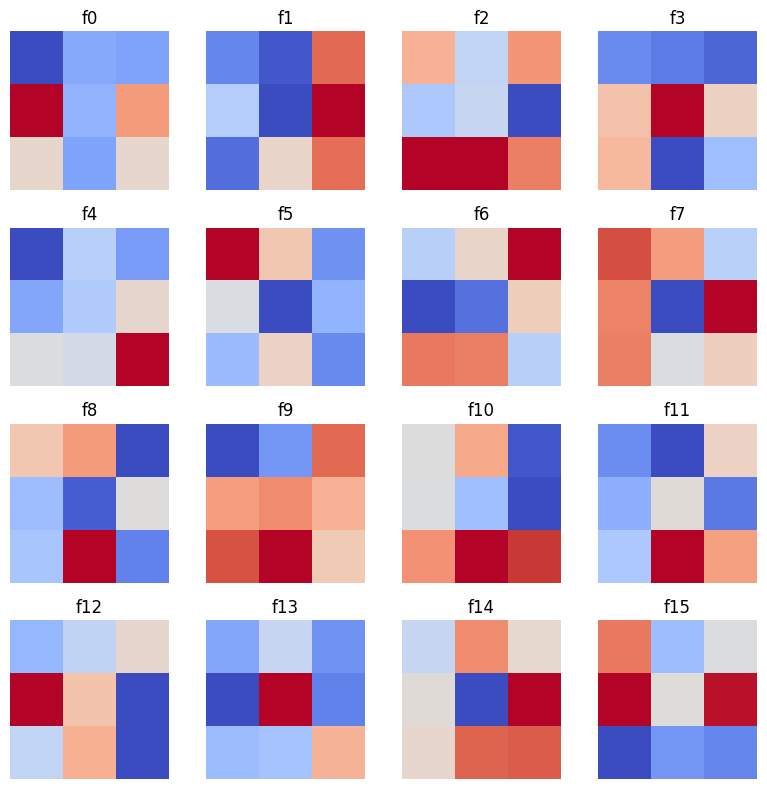

In [22]:
visualize_filters(G, "block4.conv1")

中解像度（模様・リズム）模様の繰り返し・リズム・境界

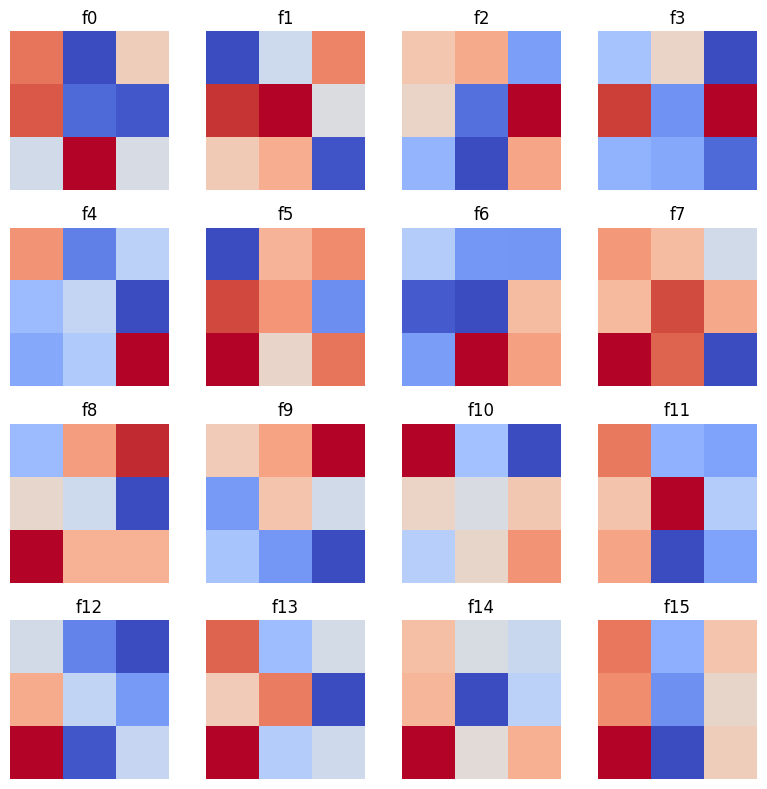

In [23]:
visualize_filters(G, "blocks.32.conv1")

高解像度（質感・色のゆらぎ）色のにじみ、テクスチャ、細部

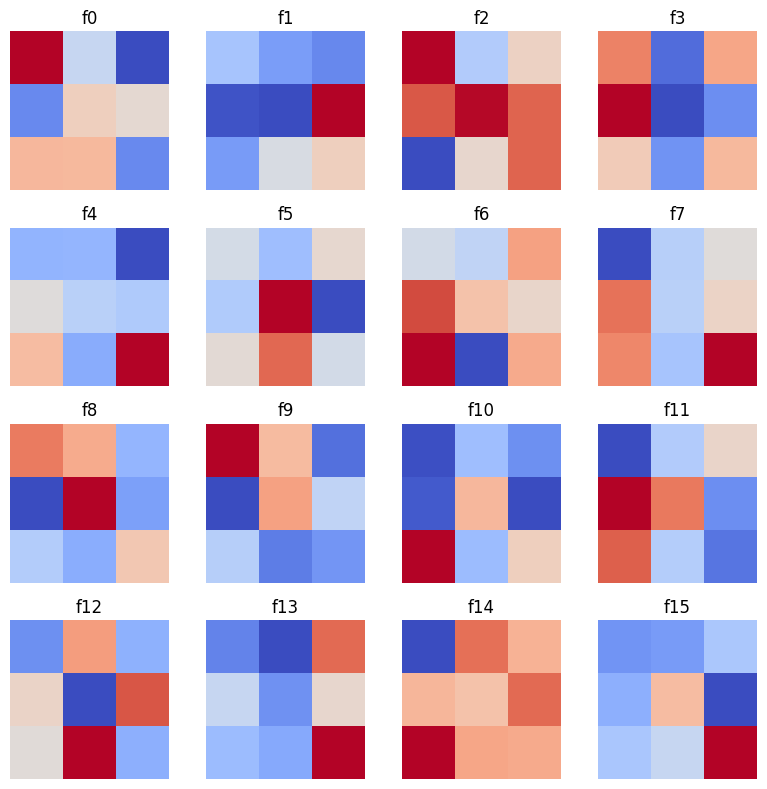

In [24]:
visualize_filters(G, "blocks.128.conv2")

まず前提整理（いま見ているもの）

いま表示している図は何か
	•	各 Convフィルタの重み（kernel） をそのまま可視化したもの
	•	3×3 の小さなパターン
	•	これは 「何に反応したいかのテンプレート」 であって
「実際にどこに反応したか」ではない

つまり：

設計図（weight）を見ている段階
↓
次にやりたいのが「反応マップ（activation）」

「意味空間」を見たいなら、次にやるべきこと

この weight 可視化は 入口です。
意味を感じたいなら、次のどれかが効きます。

やりたいこと（あなたの質問）

特定フィルタが、生成画像のどの場所で強く使われているかを可視化したい

これはまさに Activation Map（特徴マップ）可視化 です

方法の全体像（PGGAN / Generator）.  
	1.	Generatorにフックを仕掛ける.  
	2.	特定のConv層の 出力特徴マップ を取得.  
	3.	1チャネル（= 特定フィルタ）を取り出す.  
	4.	ヒートマップとして表示.  
	5.	生成画像と並べて見る.  

フィルタ反応を取得するためのフック

In [1]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu()
    return hook

② PGGAN Generator の特定層にフックを付ける.  

例：   
blocks["64"].conv1 の 最初のConv を見る場合.  
※ あなたのGでは：   
	•	blocks は ModuleDict.  
	•	key は "8" "16" "32" "64" ... の 文字列.  

In [2]:
layer_name = "blocks.64.conv1"
layer = dict(G.named_modules())[layer_name]
layer.register_forward_hook(get_activation(layer_name))

NameError: name 'G' is not defined